# Data Analysis - Mobility Project

## VENGEON Nicolas, 李想（Li Xiang), 徐振毅（Xu Zhenyi）

# Imports for the project

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

# Import of project data + cleaning

In [6]:
mel_cities = gpd.read_file('2024-project/2024-project/cartographic-resources/mel_communes.zip')
nordData = gpd.read_file('2024-project/2024-project/cartographic-resources/IRIS-GE_2-0_SHP_LAMB93_D059-2020/IRIS_GE.SHX')
dfe = gpd.read_parquet('2024-project/2024-project/cartographic-resources/mel.parquet')
bruit = gpd.read_file('2024-project/2024-project/donnees-bruit-nuit.zip')

In [261]:
lilleMetropolis = nordData[nordData.INSEE_COM.isin(mel_cities['insee']) ]
lilleMetropolis = lilleMetropolis.to_crs(3950)
lilleMetropolis.reset_index(drop=True)
True

True

In [133]:
bruit = bruit.to_crs(3950)
bruit = bruit.reset_index(drop=True)


## Key variables

In [ ]:
scoreDf = lilleMetropolis[['CODE_IRIS', 'geometry']].copy()

# Objectives: 

## Place a container near a bicycle lane in the most promising Irises. 
 ### Assign a score to each Iris based on:
- Noise level (The more, the better, to avoid quiet area)
- Proximity to business area (The closest, the better)
- Population density (The closest, the better)
 ### Selection of Iris
- Remove all the Iris where one of the score is too low (Eliminatory for the specified criterion)
- find the number x of containers to build based on the company budget
- Only keep the top x + 10 Iris, based on the agregation of their scores
- Chose x Iris in the list based of their best coverage of Lille metropolis area, considering bike time
 ### Place a container on each selected Iris, near a bycicle lane
 ------------------------------------------------------------------------------------------------------

# Assigning a score to each iris based on the noise level in the area.

## Map of noise in the Lille metropolitan area.

<Axes: title={'center': 'Map of Noise Levels in Lille Metropolis area'}>

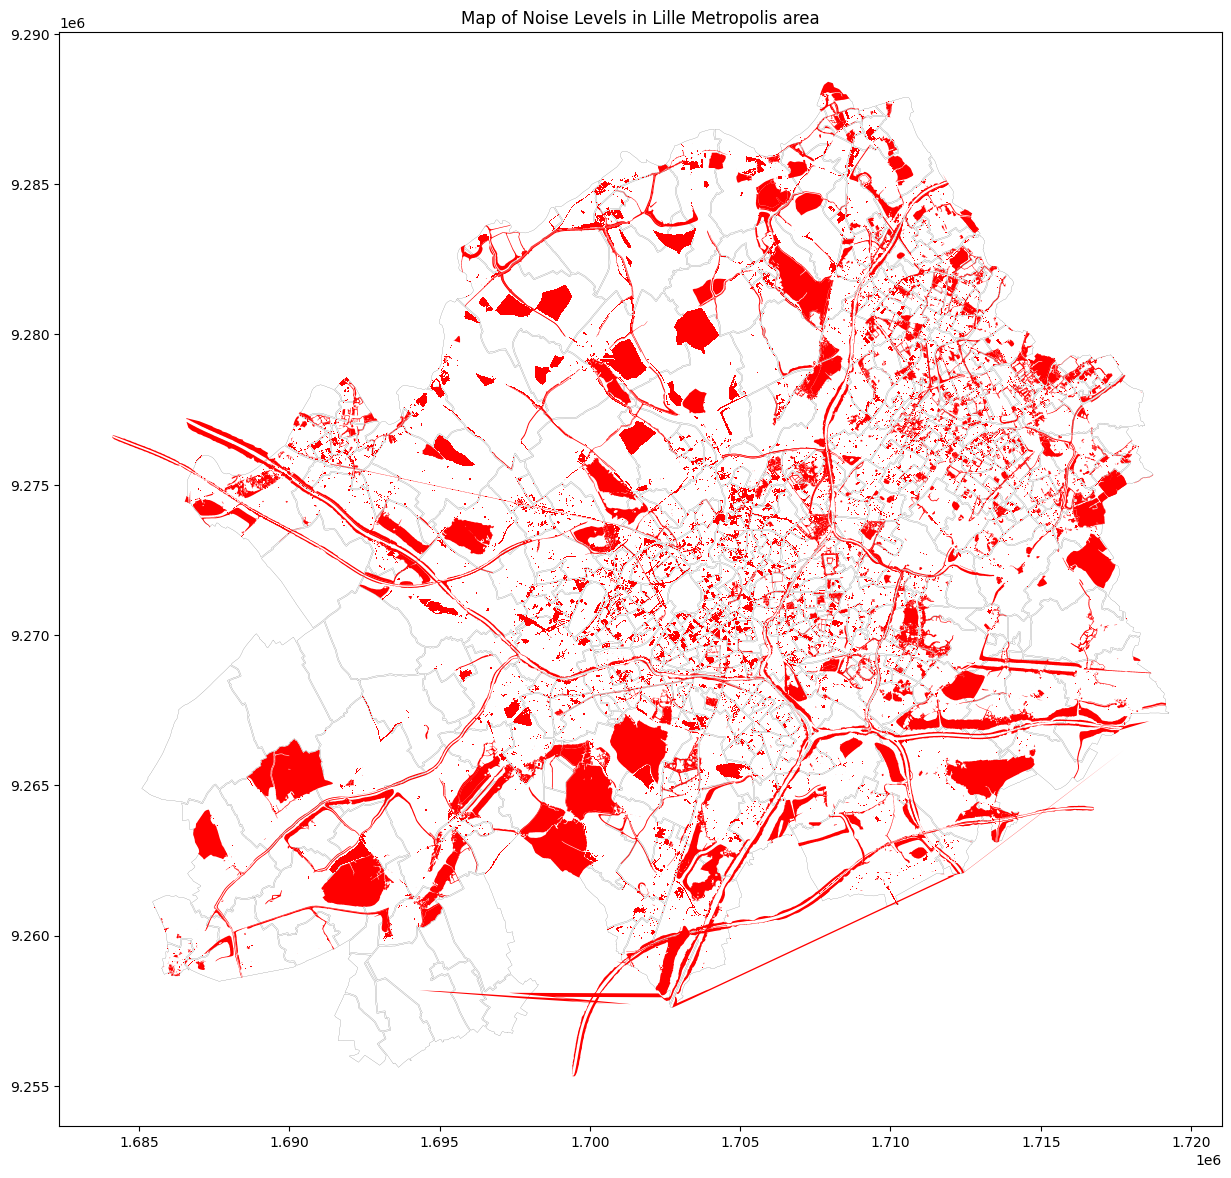

In [216]:
ax = lilleMetropolisBuffed.plot(color='white',edgecolor='black',linewidth=0.1,figsize=(15,15))
ax.set_title('Map of Noise Levels in Lille Metropolis area')
bruit.plot(ax=ax, color='red',linewidth=0.3,figsize=(15,15))

## Map of noise levels for each Iriss

### Aggregate all noise data by iris and calculate the geometric area of their intersection.




In [266]:
lilleMetropolis.drop(columns=['noise'], inplace=True)
tempLille = lilleMetropolis.copy()
tempLille['surface_iris'] = tempLille.area

result = gpd.overlay(tempLille, bruit, how='intersection')
result['intersection_area'] = result.geometry
grouped_result = result.groupby('CODE_IRIS')['intersection_area'].apply(lambda x: x.unary_union).reset_index()

combined_geometries = gpd.GeoDataFrame(grouped_result, geometry='intersection_area')
tempLille = tempLille.merge(combined_geometries, how='left', on='CODE_IRIS')



In [244]:
lilleMetropolis_merged.columns


Index(['INSEE_COM', 'NOM_COM', 'IRIS', 'CODE_IRIS', 'NOM_IRIS', 'TYP_IRIS',
       'geometry', 'surface_iris', 'intersection_area'],
      dtype='object')

### Add a new colmn on lilleMetropolis coresponding to the ratio of its area and the area off all the noise in the Iris

In [269]:
lilleMetropolis.drop(columns=['noise'], inplace=True)
tempLille['noise'] = tempLille['intersection_area'].area / tempLille.geometry.area
tempLille['noise'] = tempLille['noise'].fillna(0)
lilleMetropolis = lilleMetropolis.merge(tempLille[['CODE_IRIS', 'noise']], how='left', on='CODE_IRIS')

### Ploting of the map, using a gradient

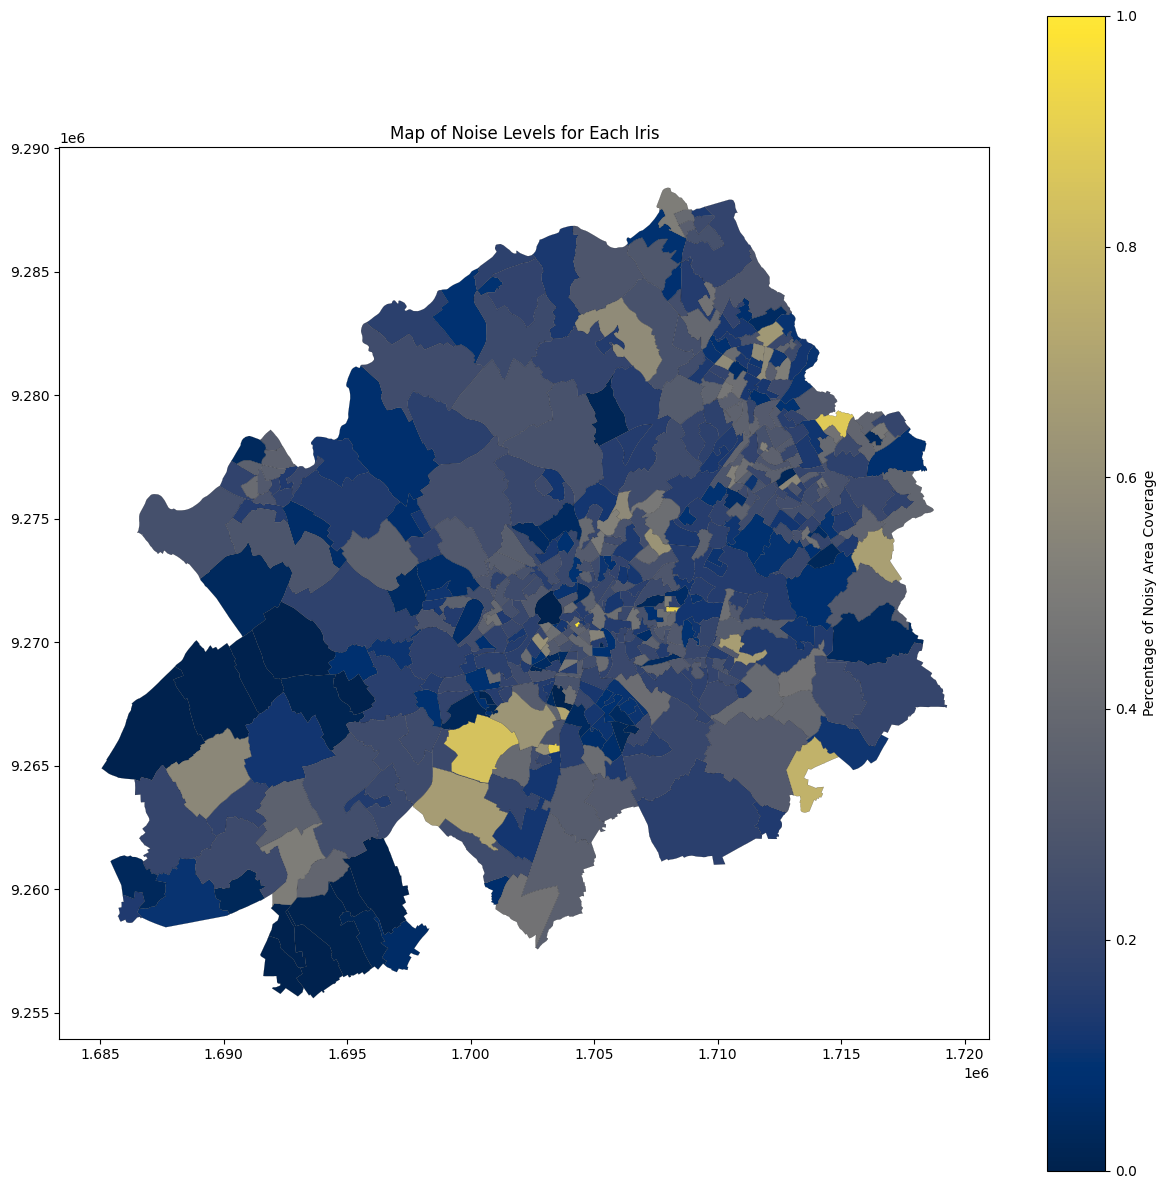

In [277]:
cmap = 'cividis'

norm = Normalize(vmin=0, vmax=1)
sm = ScalarMappable(cmap=cmap, norm=norm)

ax = lilleMetropolis.plot(column='noise', cmap=cmap, linewidth=0.1, edgecolor='black',
                                    legend=False, figsize=(15, 15))

cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='Percentage of Noisy Area Coverage')
ax.set_title('Map of Noise Levels for Each Iris')

plt.show()

### Update the score of each Iris

In [149]:
scoreDf['Noise_level'] = lilleMetropolis['ratio_intersection']

# Assigning a score to each iris based on their distance to business area

In [272]:
lilleMetropolis['Business_area'] = lilleMetropolis['TYP_IRIS'] == 'A'


In [273]:
import geopandas as gpd
from shapely.geometry import Point
import math

# Fonction pour calculer le gradient d'activité commerciale
def calculate_business_area_distance(iris, business_areas):
    if iris['Business_area'] == 1:
        return 0  # Iris dans la zone d'activité commerciale

    distances = iris['geometry'].distance(gpd.GeoSeries(business_areas))
    min_distance = distances.min()

    return min_distance

# Exemple d'utilisation
business_area_irises = lilleMetropolis[lilleMetropolis['TYP_IRIS'] == 'A']
lilleMetropolis['distanceArea'] = lilleMetropolis.apply(calculate_business_area_distance, axis=1, business_areas=business_area_irises['geometry'])

# Extract the 'distanceArea' column
distances = lilleMetropolis['distanceArea'].values.reshape(-1, 1)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the distances to scale between 0 and 1
lilleMetropolis['Business_area_gradient'] = 1 - scaler.fit_transform(distances) ** 0.2

lilleMetropolis['Business_area_gradient']

0      1.000000
1      0.222269
2      1.000000
3      0.093513
4      0.124467
         ...   
512    0.167221
513    0.165191
514    0.150156
515    0.159830
516    0.168835
Name: Business_area_gradient, Length: 517, dtype: float64

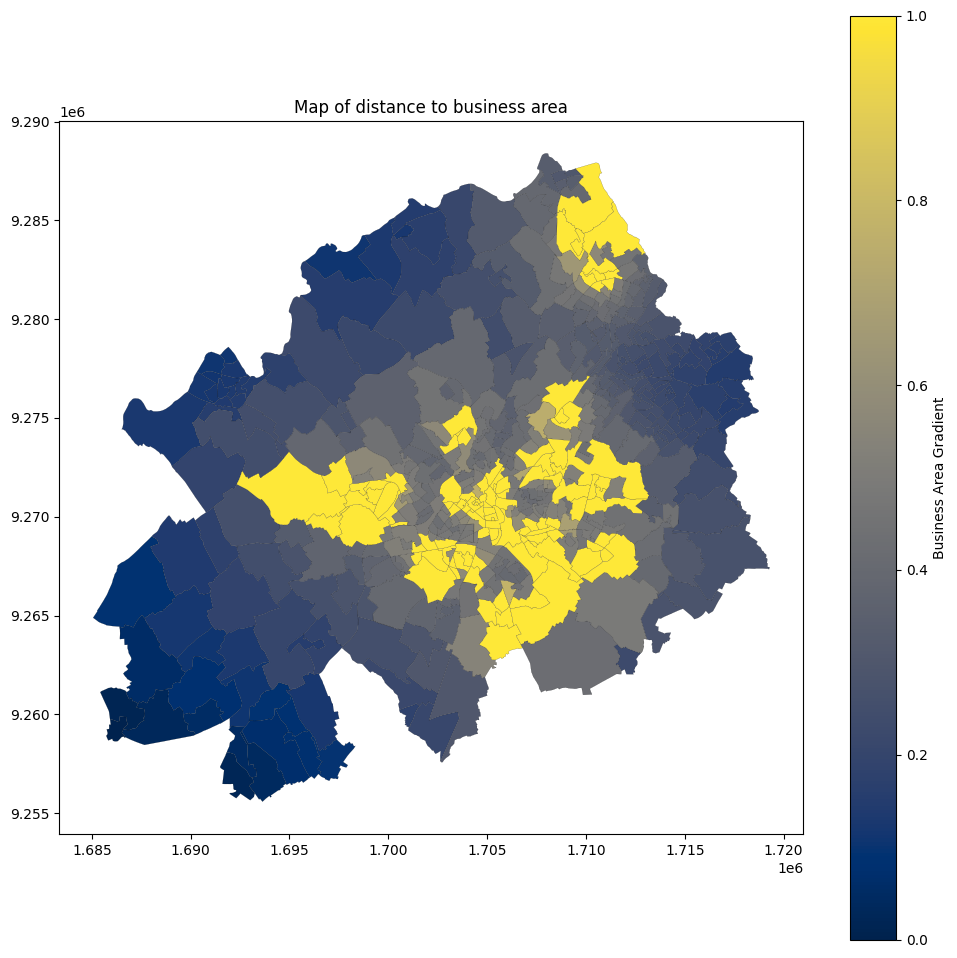

In [276]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming you have already calculated the business area gradient as described in the previous code

# Set up the colormap
cmap = 'cividis'
norm = Normalize(vmin=lilleMetropolis['Business_area_gradient'].min(),
                 vmax=lilleMetropolis['Business_area_gradient'].max())
sm = ScalarMappable(cmap=cmap, norm=norm)

# Plot the GeoDataFrame with a gradient of color
fig, ax = plt.subplots(figsize=(12, 12))
lilleMetropolis.plot(column='Business_area_gradient', cmap=cmap, linewidth=0.1, edgecolor='black',
                     legend=False, ax=ax)

# Add colorbar
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='Business Area Gradient')
ax.set_title('Map of distance to business area')

plt.show()


### Update the score of each Iris

In [282]:
scoreDf['Business_area'] = lilleMetropolis['Business_area_gradient']

# Assigning a score to each iris based on their population density

In [284]:
lilleMetropolis['superficie'] = lilleMetropolis['geometry'].area

In [ ]:
# Ajouter une colonne 'score_densite' reflétant la densité de population
lilleMetropolis2['score_densite'] = 2000 / lilleMetropolis2['superficie']

min_score_densite = lilleMetropolis2['score_densite'].min()
max_score_densite = lilleMetropolis2['score_densite'].max()
lilleMetropolis2['score_densite_normalisé'] = (lilleMetropolis2['score_densite'] - min_score_densite) / (max_score_densite - min_score_densite)
lilleMetropolis2
#lilleMetropolis_sorted_density = lilleMetropolis.sort_values(by='score_densite', ascending=False)
# Afficher le GeoDataFrame classé par densité de population
#lilleMetropolis_sorted_density